In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cPickle as pickle
import os


In [2]:
downloads = "/srv/hd7/jheuristic/Downloads/"

In [3]:
!head /srv/hd7/jheuristic/Downloads/head_20160224

y461817351456076671	1456329336	вк
y461817351456076671	1456331514	олимп
y461817351456076671	1456347405	киви
y461817431453639617	1456343089	сервисный центр htc киев
y4618174371451316085	1456312341	ютуб видеохостинг
y461817451373957074	1456303564	билайн личный кабинет
y461817451373957074	1456310563	фактор роста
y461817451373957074	1456310950	сбербанк бизнес онлайн интернет клиент
y461817451373957074	1456310967	gentdrf d fhntr regbnm
y461817451373957074	1456319105	учи.ру


In [4]:
#Препроцесснуть запросы в тот же формат, что и твиты
from collections import defaultdict


    

with open(downloads+"search_queries",'w') as fout:
    opensubtitles = defaultdict(list)


    with open(downloads+"head_20160224") as fin:
        for line in fin:
            _,i,phrase = line[:-1].split('\t')
            opensubtitles[i].append(phrase)
            
    
    for i, lines in opensubtitles.items():
        fout.write('%s\t["%s"]\n'%(i, '", "'.join(lines)))

            

            
            

# Посчитаем частоты всех токенов
И заодно прихватим длины всех предложений

In [6]:
%%time
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")


token_counts = Counter()
lengths= []

with open(downloads+"search_queries",'r') as fin:
    for ln in fin:
        ln = ln.decode('utf8')
        phrases_blob = ln.split('\t')[-1]
        
        phrases = phrases_blob[2:-2].lower().split('", "')
        
        phrases_tokens = map(tokenizer.tokenize,phrases)
        
        
        for line in phrases_tokens:
            for token in line:
                token_counts[token]+=1
        lengths += map(len,phrases)

with open(downloads+"/twitter_dialogues",'r') as fin:
    for ln in fin:
        ln = ln.decode('utf8')
        phrases_blob = ln.split('\t')[-1]
        
        phrases = phrases_blob[2:-2].lower().split('", "')
        
        phrases_tokens = map(tokenizer.tokenize,phrases)
        
        
        for line in phrases_tokens:
            for token in line:
                token_counts[token]+=1
        lengths += map(len,phrases)
        

CPU times: user 1h 2min 23s, sys: 7.06 s, total: 1h 2min 30s
Wall time: 1h 2min 28s


# Выберем порог по частоте и построим словарь

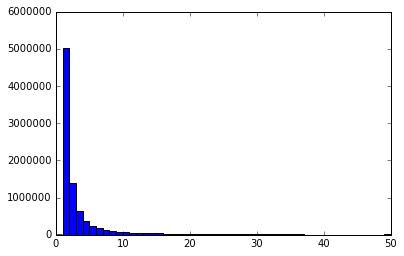

In [7]:
#распределение частот слов - большинство слов встречаются очень редко - для нас это мусор
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [8]:
#возьмём только те токены, которые встретились хотя бы 10 раз в обучающей выборке
min_count = 25


special_tokens = ["UNK","PAD"]


tokens = special_tokens+[token for (token,count) in token_counts.items() if count >= min_count ]

token_to_id = {t:i for i,t in enumerate(tokens)}




n_tokens = len(token_to_id)
print "Всего токенов:",n_tokens
print "Покрытие выборки:",sum(map(token_counts.get,tokens[2:])) *1./ sum(token_counts.values())

Всего токенов: 613931
Покрытие выборки: 0.974494020142


# Выберем предельную длину

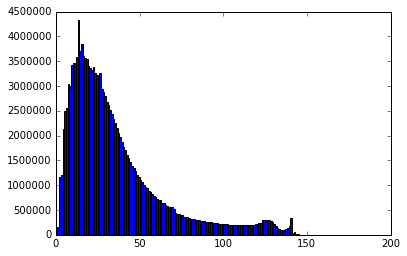

In [9]:
#Распределение на длину
_=plt.hist(lengths,range=[0,200],bins=200)

In [10]:
max_len = 150
print "Покрытие по длине:",(np.array(lengths)<=max_len).mean()

Покрытие по длине: 0.998917834726


In [16]:
with open(downloadsnloadsnloads + "metadata",'w') as fout:
    pickle.dump((tokens,token_to_id,n_tokens,min_count,max_len),fout)

In [4]:
# Порежем выборку на train/test
# я просто оставлю это сдесь на случай, если ты перезапустил всё во време шаффла и убил данные 

def split(infile, N,outfile_before,outfile_after):
    os.system("head -n %i %s > %s" % (N,infile,outfile_before))
    os.system("tail -n +%i %s > %s" % (N+1,infile,outfile_after))


split(downloads+"twitter_dialogues", 13000000, downloads+"twitter_train",downloads+"twitter_test")
split(downloads+"search_queries", 50000, downloads+"queries_train",downloads+"queries_test")


# Применение
Теперь тетрадку можно гонять начиная с этой табы

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cPickle as pickle
downloads = "/srv/hd7/jheuristic/Downloads/"


# Токенизируем примеры

Сначала соберём словарь всех возможных слов.
Поставим каждому слову в соответствие целое число - его id

In [5]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")


In [6]:
with open(downloads+"metadata",'r') as fin:
    (tokens,token_to_id,n_tokens,min_count,max_len) = pickle.load(fin)


print n_tokens,min_count,max_len

613931 25 150


### Заменим слова на их id
Для каждого описания установим максимальную длину. 
 * Если описание больше длины - обрежем, если меньше - дополним нулями.
 * Таким образом, у нас получится матрица размера (число объявлений)x(максимальная длина)
 * Элемент под индексами i,j - номер j-того слова i-того объявления

In [7]:
import random
def shuffle_lines(fname):
    lines = open(fname).readlines()
    random.shuffle(lines)
    open(fname, 'w').writelines(lines)

In [8]:
from itertools import izip
def FileIterator(filename, token_to_id,
                 batch_size=10,max_len=max_len,
                 null_token=0,padding_token=1, 
                 pre_shuffle=False,shuffle=True
                 
                     ):
    
    if pre_shuffle:
        print "shuffling",filename,"..."
        shuffle_lines(filename)

    batch_ix = []

    while True:

        with open(filename) as fin:

            for ln in fin:
                
                ln = ln.decode('utf8')
                phrases_blob = ln.split('\t')[-1]
                phrases = phrases_blob[2:-2].lower().split('", "')
                phrases_tokens = map(tokenizer.tokenize,phrases)
                
                for phrase_tokens in phrases_tokens:
                    token_ids = map(lambda token: token_to_id.get(token,null_token), phrase_tokens)[:max_len]
                    token_ids += [padding_token]*(max_len - len(token_ids))
                    
                    
                    batch_ix.append(token_ids)
                    
                    if len(batch_ix) ==batch_size: 
                        #Batch generated
                        yield np.array(batch_ix,dtype='int32')
                        batch_ix = []
        if shuffle:
            print "shuffling",filename,"..."
            shuffle_lines(filename)


# Поучим нейронку

Поскольку у нас есть несколько источников данных, наша нейронная сеть будет немного отличаться от того, что вы учили раньше.

* Отдельный вход для заголовка
 * свёртка + global max pool или RNN
* Отдельный вход для описания
 * свёртка + global max pool или RNN
* Отдельный вход для категориальных признаков
 * обычные полносвязные слои или какие-нибудь трюки
 
Всё это нужно как-то смешать - например, сконкатенировать

* Выход - обычный двухклассовый выход
 * 1 сигмоидальный нейрон и binary_crossentropy
 * 2 нейрона с softmax и categorical_crossentropy - то же самое, что 1 сигмоидальный
 * 1 нейрон без нелинейности (lambda x: x) и hinge loss
 

In [9]:
%env THEANO_FLAGS="device=gpu3"
#загрузим библиотеки
import lasagne
from theano import tensor as T
import theano

env: THEANO_FLAGS="device=gpu3"


Using gpu device 3: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [10]:
#3 входа и 1 выход
input_text_ids = T.matrix("phrase_token_ids",dtype='int32')

target_y = T.ivector("is_blocked")

# Архитектура нейронной сети

In [11]:

text_inp = lasagne.layers.InputLayer((None,max_len),input_var=input_text_ids)


nn = lasagne.layers.EmbeddingLayer(text_inp,input_size=len(token_to_id)+1,output_size=128)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=256,filter_size=3)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=256,filter_size=3)
nn = lasagne.layers.Pool1DLayer(nn,3)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=512,filter_size=3)
nn = lasagne.layers.Pool1DLayer(nn,3)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=1024,filter_size=3)


nn = lasagne.layers.ExpressionLayer(nn,function=lambda v: v.max(axis=1),
                                    output_shape=lambda inp_shape:inp_shape[:1]+inp_shape[2:])





nn = lasagne.layers.DenseLayer(nn,2048)
nn = lasagne.layers.DropoutLayer(nn,p=0.1)
nn = lasagne.layers.DenseLayer(nn,2048)

nn = lasagne.layers.DenseLayer(nn,2,nonlinearity=lasagne.nonlinearities.softmax)

# Целевая функция и обновления весов

* Делаем всё стандартно:
 * получаем предсказание
 * считаем функцию потерь
 * вычисляем обновления весов
 * компилируем итерацию обучения и оценки весов

In [12]:
#Все обучаемые параметры сети
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [13]:
#Обычное предсказание нейронки
prediction = lasagne.layers.get_output(nn)


#функция потерь для prediction
loss = lasagne.objectives.categorical_crossentropy(prediction,target_y).mean()



In [14]:
#Шаг оптимизации весов
updates = lasagne.updates.adadelta(loss,weights)

### Чтобы оценивать качество сети, в которой есть элемент случайности 
 * Dropout, например,
 * Нужно отдельно вычислить ошибку для случая, когда dropout выключен (deterministic = True)
 * К слову, неплохо бы убедиться, что droput нам вообще нужен

In [15]:
#Предсказание нейронки без учёта dropout и прочего шума - если он есть
det_prediction = lasagne.layers.get_output(nn,deterministic=True)

#функция потерь для det_prediction
det_loss = lasagne.objectives.categorical_crossentropy(det_prediction,target_y).mean()


### Скомпилируем функции обучения и оценки качества

In [16]:
train_fun = theano.function([input_text_ids,target_y],[loss,prediction[:,1]],updates = updates)
eval_fun = theano.function([input_text_ids,target_y],[det_loss,det_prediction[:,1]])

# Главный цикл обучения
* Всё как обычно - в цикле по минибатчам запускаем функцию обновления весов.
* Поскольку выборка огромна, а чашки чая хватает в среднем на  100к примеров, будем на каждой эпохе пробегать только часть примеров.

In [17]:
# наш старый знакомый - итератор по корзинкам - теперь умеет работать с произвольным числом каналов (название, описание, категории, таргет)
from itertools import izip
def iterate_minibatches(corpora_0,corpora_1,
                        batch_0= 50,batch_1=50,
                        seq_len=max_len):
    
    itr_0 = FileIterator(corpora_0,token_to_id,
                         batch_0,seq_len,)
    itr_1 = FileIterator(corpora_1,token_to_id,
                         batch_1,seq_len,)
    
    batch_y = np.concatenate([np.zeros(batch_0,dtype='int32'),np.ones(batch_1,dtype='int32')])
    
    for batch_x0,batch_x1 in izip(itr_0,itr_1):
        
        batch_x = np.concatenate([batch_x0,batch_x1],axis=0)
        
        yield batch_x,batch_y


In [18]:
batch_size = 100
minibatches_per_epoch = 10**2
n_epochs=1000

In [19]:
train_iterator = iterate_minibatches(
    downloads+"queries_train",downloads+"twitter_train",
    batch_size/2,batch_size/2,max_len
)
test_iterator = iterate_minibatches(
    downloads+"queries_test",downloads+"twitter_test",
    batch_size/2,batch_size/2,max_len
)

In [21]:
from collections import defaultdict

metrics = defaultdict(dict)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score



for e in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_x, b_y) in enumerate(train_iterator):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_x,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    e_loss = b_loss/b_c
    e_acc = accuracy_score(epoch_y_true,epoch_y_pred>0.5)
    e_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
    print "Train:"
    print '\tloss:',e_loss
    print '\tacc:',e_acc
    print '\tauc:',e_auc
    metrics["train loss"][e] = e_loss
    metrics["train accuracy"][e] = e_acc
    metrics["train auc"][e] = e_auc
    
    
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_x, b_y) in enumerate(test_iterator):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_x,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    
    e_loss = b_loss/b_c
    e_acc = accuracy_score(epoch_y_true,epoch_y_pred>0.5)
    e_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
    print "Val:"
    print '\tloss:',e_loss
    print '\tacc:',e_acc
    print '\tauc:',e_auc
    metrics["val loss"][e] = e_loss
    metrics["val accuracy"][e] = e_acc
    metrics["val auc"][e] = e_auc



Train:
	loss: 0.691251374707
	acc: 0.549900990099
	auc: 0.562181178316
Val:
	loss: 0.677201169552
	acc: 0.565247524752
	auc: 0.586509440251
Train:
	loss: 0.651603195337
	acc: 0.607227722772
	auc: 0.641987393393
Val:
	loss: 0.443201591915
	acc: 0.811188118812
	auc: 0.871684560337
Train:
	loss: 0.287094845335
	acc: 0.883762376238
	auc: 0.947513988825
Val:
	loss: 0.236613580053
	acc: 0.90495049505
	auc: 0.965324183904
Train:
	loss: 0.223904199161
	acc: 0.915841584158
	auc: 0.967981080286
Val:
	loss: 0.212683215664
	acc: 0.915148514851
	auc: 0.971045544554
Train:
	loss: 0.205314013037
	acc: 0.920594059406
	auc: 0.973062738947
Val:
	loss: 0.197242758209
	acc: 0.924158415842
	auc: 0.975154278992
Train:
	loss: 0.185870978576
	acc: 0.932871287129
	auc: 0.97740096069
Val:
	loss: 0.192626110841
	acc: 0.926435643564
	auc: 0.976658131556
Train:
	loss: 0.164206608798
	acc: 0.937524752475
	auc: 0.98270271542
Val:
	loss: 0.179265788507
	acc: 0.932673267327
	auc: 0.979655171062
Train:
	loss: 0.1754051

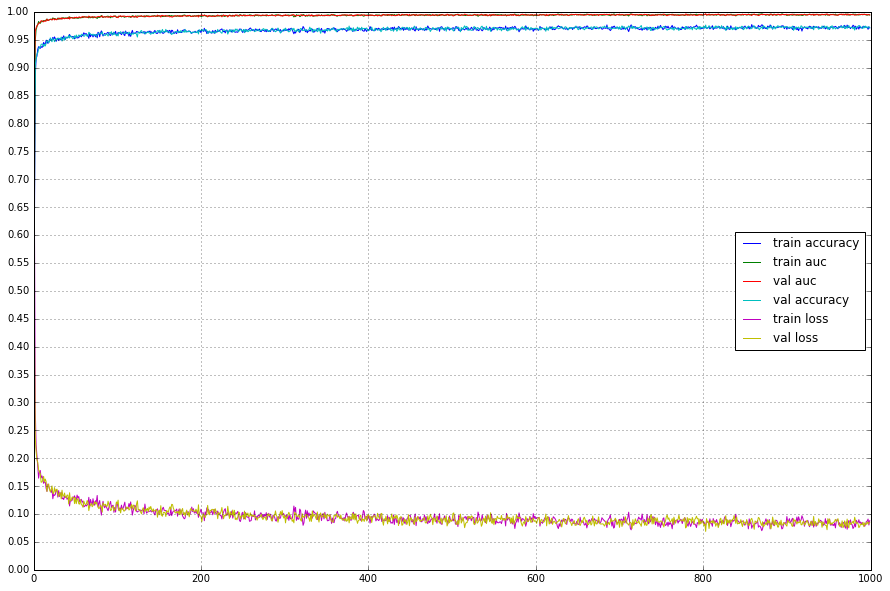

In [27]:
plt.figure(figsize=[15,10])
for metric_name in metrics:
    
    x,y = zip(*sorted(metrics[metric_name].items(), key = lambda tpl:tpl[0]))
    
    plt.plot(x,y,label=metric_name)
plt.legend(loc="best")
plt.ylim([0,1])
plt.yticks(np.arange(21)/20.)
plt.grid()

In [28]:
print "Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. \nНет, честно, file->make a copy"

Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. 
Нет, честно, file->make a copy


In [29]:
#evaluation
epoch_y_true = []
epoch_y_pred = []
epoch_x = []
b_c = b_loss = 0
for j, (b_x, b_y) in enumerate(test_iterator):
    if j > minibatches_per_epoch:break

    loss,pred_probas = train_fun(b_x,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)
    epoch_x.append(b_x)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)
epoch_x = np.concatenate(epoch_x)

In [31]:
margin = ( (epoch_y_pred -0.5) * (epoch_y_true-0.5))

worst = np.argsort(margin)[:50]


for i in worst:
    
    t_seq = map(tokens.__getitem__,epoch_x[i])
    
    print  ["query","twitter"][int(epoch_y_true[i])], '->\t', ' '.join(filter(lambda s: s!="PAD",t_seq))

query ->	поэтому утверждать что все они русские как минимум некорректно проснулся во мне историк не знаю UNK это рожденный ради мира это UNK
query ->	в о
twitter ->	сочинение рассуждение на лингвистическую тему нет нет не слышали
query ->	весь мир хуйня а бабы бляди а солнце ебаный фанарь
query ->	попытка оценивать чужую культуру сравнивая ее с собственной определяется как
query ->	самый лучший день вот и осталось
query ->	хххл хд
twitter ->	казаки разбойники на раздевание
twitter ->	гонки
query ->	я сам
query ->	знал бы прикуп жил бы в сочи
twitter ->	мтс выдаёт ошибку 451
query ->	счастье свое я нашел в нашей дружбе с тобой
twitter ->	смотреть одновременно 4 матча нездорово
twitter ->	банши
twitter ->	лаконичная наташа
twitter ->	топ модель по американски
query ->	давай UNK
twitter ->	дмитрий сон вк город москва
query ->	какое сегодня число
twitter ->	ул блондина дом 23
twitter ->	кит ричардс пишет автобиографию для детей
twitter ->	ребенку годик температура 38 39 три дня подряд инте